# Build Visualizations for Rating Evaluation


In [164]:
# Get role and person to compare
person_id = 5


## Import Libraries

In [165]:
import pandas as pd
import numpy as np

# Get Employees Data

In [166]:
# Read the employees dataset - from the data entered in the survey
df_people = pd.read_csv(filepath_or_buffer=f"../2-data/survey_people.csv", sep=",", encoding="latin1")

# Get only required columns
#df_people = df_people[(df_people['id']==person_id_1) | (df_people['id']==person_id_2) | (df_people['id']==person_id_3)]
#df_people = df_people[df_people['id']==person_id]

df_people = df_people[['id', 'skills', 'skills-want']]

# Tokenize the skills
df_people['skills'] = df_people['skills'].apply(lambda x: x.replace("'", ""))
df_people['skills'] = df_people['skills'].apply(lambda x: x.replace("[", ""))
df_people['skills'] = df_people['skills'].apply(lambda x: x.replace("]", ""))

df_people['skills'] = df_people['skills'].apply(lambda x: x.split(';'))
#df_people['skills'] = df_people['skills'].apply(set)

df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.replace("'", ""))
df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.replace("[", ""))
df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.replace("]", ""))
df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.split(';'))
#df_people['skills-want'] = df_people['skills-want'].apply(set)


df_people


,id,skills,skills-want
0,1,"[Java, JavaScript, Python, SQL, MySQL, SQLite,...","[Dart, Java, SQL, MySQL, SQLite]"
1,2,"[C++, HTML/CSS, Java, JavaScript, PHP, Python,...","[HTML/CSS, JavaScript, TypeScript, AWS, Fireba..."
2,3,"[C++, HTML/CSS, Java, PHP, Python, SQL, MariaD...","[Python, MySQL, SQLite, Unity 3D, Unreal Engine]"
3,4,"[HTML/CSS, JavaScript, Kotlin, TypeScript, AWS...","[HTML/CSS, JavaScript, TypeScript, AWS, Fireba..."
4,5,"[C#, Java, JavaScript, PHP, PowerShell, Python...","[Python, R, SQL, Microsoft SQL Server, MySQL, ..."
5,6,"[MATLAB, Python, R, SQL, Swift, Cassandra, Cou...","[Python, Microsoft SQL Server, MongoDB, Neo4j,..."
6,7,"[Bash/Shell, PowerShell, Python, Scala, SQL, M...","[Python, R, Scala, Microsoft SQL Server, Mongo..."
7,8,"[Bash/Shell, C#, C++, Java, PowerShell, Python...","[C#, Python, SQL, Cassandra, MariaDB, Microsof..."
8,9,"[Assembly, Bash/Shell, C#, C++, Go, HTML/CSS, ...","[C#, Go, HTML/CSS, Java, JavaScript, PowerShel..."
9,10,"[MATLAB, Python, R, SQL, Microsoft SQL Server,...","[C++, Python, Scala, DynamoDB, MongoDB, MySQL,..."


In [167]:
df_person_skills = df_people.explode('skills')[['id', 'skills']]
df_person_skills['skills'] = df_person_skills['skills'].str.strip()
df_person_skills#['source'] = 'person-skills'


,id,skills
0,1,Java
0,1,JavaScript
0,1,Python
0,1,SQL
0,1,MySQL
...,...,...
19,20,Docker
19,20,Homebrew
19,20,Kubernetes
19,20,npm


In [168]:
df_person_interests = df_people.explode('skills-want')[['id', 'skills-want']]
df_person_interests['skills'] = df_person_interests['skills-want']
#df_person_interests['source'] = 'person-interests'
#df_person_interests = df_person_interests[['id', 'skills', 'source']]
df_person_interests = df_person_interests[['id', 'skills']]
df_person_interests['skills'] = df_person_interests['skills'].str.strip()
df_person_interests


,id,skills
0,1,Dart
0,1,Java
0,1,SQL
0,1,MySQL
0,1,SQLite
...,...,...
19,20,TensorFlow
19,20,Torch/PyTorch
19,20,Docker
19,20,Kubernetes


# Compute Number for each combination

In [169]:
from sqlalchemy import create_engine

def create_table(name, df):
    # Create a connection to the database
    engine = create_engine('sqlite:///database.db')

    # Load the DataFrame into a table
    df.to_sql(f'{name}', engine, if_exists='replace', index=False)

    # Close the database connection
    engine.dispose()

create_table('person_skills', df_person_skills)
create_table('person_interests', df_person_interests)


In [170]:
def query_database(sql):
    # Create a connection to the database
    engine = create_engine('sqlite:///database.db')

    # Query the data
    query = sql
    result = engine.execute(query)

    # Fetch all the rows from the result object
    rows = result.fetchall()

    # Convert the rows to a DataFrame
    df_result = pd.DataFrame(rows, columns=result.keys())

    # Close the database connection
    engine.dispose()

    return df_result


In [171]:
def compute_matched_skills_only(person):
    # Get skills only
    result = query_database(f"""
        select distinct(ps.skills) from person_interests pi, person_skills ps 
        where ps.id = {person} and ps.skills not in (
            select skills from person_interests where id = {person});
        """)
    result
    matched_skills_only = result.count()[0]
    return matched_skills_only



def compute_matched_skills_and_interests(person):
    
    # Get skills and interests
    result = query_database(f"""
        select distinct(ps.skills) from person_skills ps where ps.id = {person} and ps.skills in (select skills from person_interests where id = {person});
        """)
    result
    matched_skills_and_interests = result.count()[0]
    return matched_skills_and_interests


def compute_matched_interests_only(person):
    # Get interests only
    result = query_database(f"""
        select distinct(pi.skills) from person_skills ps, person_interests pi where pi.id = {person} and pi.skills not in (select skills from person_skills where id = {person});
        """)
    result
    matched_interests_only = result.count()[0]
    return matched_interests_only


def get_all_skills(person):
    # Get interests only
    result = query_database(f"""
        select distinct(skills) from
        (select skills as skills from person_skills where id = {person}
        union all
        select skills as skills from person_interests where id = {person}) t
        """)
    result
    matched_interests_only = result.count()[0]
    return matched_interests_only



In [172]:

print(compute_matched_skills_only(person_id))
print(compute_matched_skills_and_interests(person_id))
print(compute_matched_interests_only(person_id))



9
16
3


# See Results

In [173]:
print("Total Number of Skills:", get_all_skills(person_id))
print("Skills only:", compute_matched_skills_only(person_id))
print("Skills and Interests:", compute_matched_skills_and_interests(person_id))
print("Interests only:", compute_matched_interests_only(person_id))



Total Number of Skills: 28
Skills only: 9
Skills and Interests: 16
Interests only: 3


In [177]:
# Create a sample DataFrame
data = {
    'Category': [f'1'],
    'Skills only': [compute_matched_skills_only(1)],
    'Skills and Interests': [compute_matched_skills_and_interests(1)],
    'Interests only': [compute_matched_interests_only(1)]
}
df = pd.DataFrame(data)

for person in range(2,21):
    data = {
    'Category': [f'{person}'],
    'Skills only': [compute_matched_skills_only(person)],
    'Skills and Interests': [compute_matched_skills_and_interests(person)],
    'Interests only': [compute_matched_interests_only(person)]
    }
    
    df = df.append(pd.DataFrame(data), ignore_index=True)

df['total'] = df[['Skills only', 'Skills and Interests', 'Interests only']].sum(axis=1)

df['order'] = df['Skills only'] / df['total']

df = df.sort_values(by=['order'], ascending=False)

df

,Category,Skills only,Skills and Interests,Interests only,total,order
11,12,34,10,0,44,0.772727
18,19,4,2,0,6,0.666667
2,3,8,5,0,13,0.615385
5,6,23,12,4,39,0.589744
15,16,20,1,14,35,0.571429
17,18,24,14,5,43,0.558140
13,14,6,0,6,12,0.500000
7,8,13,13,3,29,0.448276
0,1,4,4,1,9,0.444444
6,7,15,9,10,34,0.441176


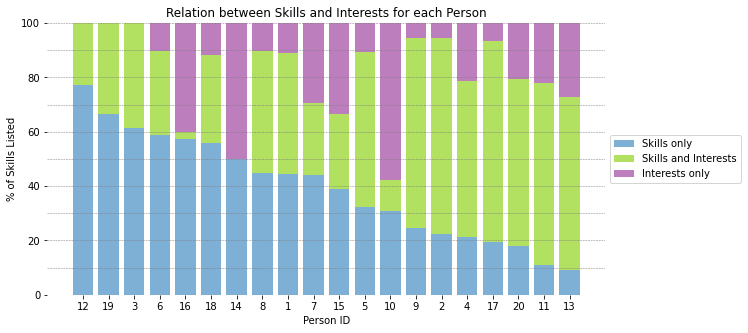

In [178]:
import matplotlib.pyplot as plt


# Calculate the percentage for each value in each category
total = df[['Skills only', 'Skills and Interests', 'Interests only']].sum(axis=1)
df_percent = df[['Skills only', 'Skills and Interests', 'Interests only']].div(total, axis=0) * 100

# Plot the 100% stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))
categories = df['Category']
bar_width = 0.8

bottom = [0] * len(categories)
colors = ['#7eb0d5', '#b2e061', '#bd7ebe']

for i, col in enumerate(df_percent.columns):
    values = df_percent[col]
    ax.bar(categories, values, bar_width, bottom=bottom, color=colors[i], label=col)
    bottom += values

ax.set_ylabel('% of Skills Listed')
ax.set_xlabel(f'Person ID')
ax.set_title(f'Relation between Skills and Interests for each Person')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the left and bottom spines
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

scale_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Specify the values for horizontal lines
for value in scale_values:
    ax.axhline(value, color='gray', linestyle='--', linewidth=0.5)

plt.show()


In [437]:
# Save chart
#plt.savefig(f'rating_role_{role_id}.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>